In [16]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import pandas as pd
import seaborn as sns
from scipy.fft import fft, fftfreq

# Generating Data

In [17]:
def generate_data(random_state = 42): 
    data = spectrum(
        sampling_rate=1000,
        duration=30,
        aperiodic_exponent=2.0,
        aperiodic_offset=2.0,
        knee=200,
        peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
        average_firing_rate=0.0,
        random_state=random_state,
        direct_estimate=True,
    )
    return data

data = generate_data()
data_td = data.time_domain.combined_signal
data_fd = data.frequency_domain

# Single-Taper (no Welch)

In [18]:
from scipy.signal import periodogram

def single_taper_psd(signal, window_length_sec, taper_shape, fs=1000):
    N = int(fs * window_length_sec)
    x = signal[-N:] # obtain last chunk
    freqs, psd = periodogram(x, fs=fs, window=taper_shape, scaling='density', return_onesided=True)
    # drop nyquist bin
    if freqs[-1] == fs / 2:
        freqs = freqs[:-1]
        psd = psd[:-1]
    return freqs, psd

# Multitaper

In [19]:
from spectral_connectivity import Multitaper, Connectivity 

def multitaper_psd(signal, window_length_sec, TW = 1, K = None, fs=1000):
    N = int(fs * window_length_sec)
    x = signal[-N:] # obtain last chunk
    
    mt = Multitaper(time_series = x, sampling_frequency = fs, time_halfbandwidth_product=TW, n_tapers = K)
    
    connectivity = Connectivity.from_multitaper(mt)
    freqs = connectivity.frequencies # dim:(250,)
    psd = connectivity.power().reshape(-1) # flatten (250, ) --> (1, 250, 1)
    return freqs, psd

In [ ]:
from scipy.signal import windows
from scipy.signal.windows import dpss

def u_scaling(fft_result_single, taper_shape, N): # https://www.mathworks.com/help/signal/ug/nonparametric-methods.html#f12-16152 
    # Scale the FFT results for single taper
    window = windows.get_window(taper_shape, N)
    U = 1/N * sum(i**2 for i in window)
    scaled_fft_single = [i/U for i in np.abs(fft_result_single)]
    return scaled_fft_single

def single_taper_no_welch(signal, window_length, taper_shape, fs=1000):
    """
    Args: 
    - signal: signal, time domain 
    - window_length: in seconds
    - taper_shape: string, desired taper
    - fs: sampling frequency, default = 1000

    Returns:
    - freqs: positive frequencies
    - psd: estimated power spectral density for positive frequencies (doubled)
    """
    N = int(window_length * fs)  # number of samples in window
    signal = signal[-N:] # last window segment of signal
    tapered_signal = signal * windows.get_window(taper_shape, N)
    freqs = np.fft.fftfreq(N, d=1/fs)[1:N//2] # starting from 1 to avoid a divide by 0 error later.
    psd = ((np.abs(fft(tapered_signal)[1:N//2]))**2) / (fs*N)
    return u_scaling(freqs, taper_shape, N), psd

def multitaper(signal, window_length, fs=1000, TW=1, K=1): # only TW and Window length
    """
    Args: 
    - signal: time domain 
    - window_length: size of window (in s)
    - fs: sampling frequency, default = 1000
    - TW: time bandwidth, default = 1
    - K: number of tapers, default = 1

    Returns:
    - freqs: positive frequencies
    - psd: estimated power spectral density for positive frequencies (doubled)
    """

    N = int(window_length * fs)  # number of samples in window
    signal = signal[-N:] # last window segment of signal

    # default to 2*NW - 1 tapers
    K = K or int(2 * TW - 1)

    # create dpss tapers
    tapers = dpss(N, TW, K)  # shape: (K, N)

    # Apply each taper to the signals
    
    tapered_signals = np.array(
        [np.abs(fft(signal * taper)) ** 2 / (fs * N * (1/N * np.sum(tapers ** 2))) for taper in tapers] 
    )  # Convert to power  1 / (fs * N) * |FFT|^2 and divide by Welch normalization factor U = 1/L * Σ w(n)^2

    fft_sum = np.sum(tapered_signals, axis=0) # summed PSD across taper

    psd = fft_sum / K  # Average PSD
    freqs = fftfreq(N, d=1/fs)

    return freqs[freqs >= 0], 2*psd[freqs >= 0] # only want positive frequencies

# Plotting

Text(13, 0.0025, '12 Hz')

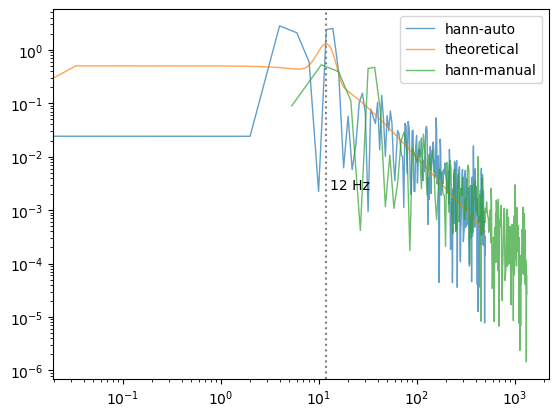

In [25]:
window_length = 0.5 # in seconds

freq_hann, psd_hann = single_taper_psd(data_td, window_length, 'hann')
freq_hamming, psd_hamming = single_taper_psd(data_td, window_length, 'hamming')
freq_mt, psd_mt = multitaper_psd(data_td, window_length, TW = 1)
freq_theo, psd_theo = data_fd.frequencies, data_fd.combined_spectrum

plt.loglog(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann-auto')
#plt.loglog(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
#plt.loglog(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper')
plt.loglog(freq_theo, psd_theo, linewidth=1, alpha=0.7, label='theoretical')

freq_hann, psd_hann = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hann')
freq_hamming, psd_hamming = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hamming')
freq_mt, psd_mt = multitaper(data_td, window_length=window_length, TW=2)

plt.loglog(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann-manual')
#plt.loglog(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
#plt.loglog(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper (scaled)')

plt.legend()

plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 0.0025,'12 Hz')

# Bias Function

In [22]:
def calc_mean_bias(empiricalPSD, theoreticalPSD):
    N = len(theoreticalPSD)
    biases = abs(empiricalPSD - theoreticalPSD) # do we need to change this cuz the empirical length is 251 while theoretical length is 250
    meanBias = np.sum(biases)/N
    return meanBias

# Violin Plots

In [23]:
window_length = 0.05
 
freq_theo, psd_theo = data_fd.frequencies, data_fd.combined_spectrum

df = pd.DataFrame(columns=['hamming_mean_bias', 'hann_mean_bias', 'multitaper_mean_bias'])
for random_state in range(100): # generate data multiple times

    data = generate_data(random_state=random_state)
    data_td = data.time_domain.combined_signal
    data_fd = data.frequency_domain
    
    freq_hann, psd_hann = single_taper_psd(data_td, window_length_sec=window_length, taper_shape='hann')
    freq_hamming, psd_hamming = single_taper_psd(data_td, window_length_sec=window_length, taper_shape='hamming')
    freq_mt, psd_mt = multitaper_psd(data_td, window_length_sec=window_length)

    psd_theo_interp = np.interp(freq_hann, freq_theo, psd_theo) # interpolate to match shape

    df.loc[len(df)] = [calc_mean_bias(psd_hamming, psd_theo_interp),
                       calc_mean_bias(psd_hann, psd_theo_interp), 
                       calc_mean_bias(psd_mt, psd_theo_interp)]

<Axes: title={'center': 'Bias by Taper Method, Window Length = 0.05s'}>

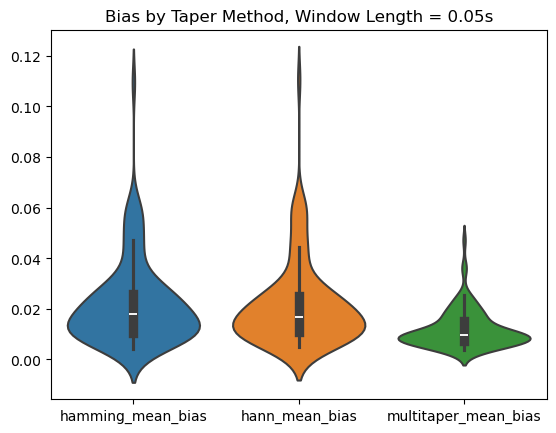

In [24]:
plt.title(f"Bias by Taper Method, Window Length = {window_length}s")
sns.violinplot(data=df, linewidth=1.5)